In [6]:
import os
import numpy as np
import IPython
import copy
from shutil import copyfile

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base


import sys
sys.dont_write_bytecode=True

PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from influence.inceptionModel import BinaryInceptionModel
from influence.logisticRegressionWithLBFGS import LogisticRegressionWithLBFGS
import influence.experiments
from influence.dataset import DataSet
# from influence.dataset_poisoning import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.iter_attack import iterative_attack, select_examples_to_attack, get_projection_to_box_around_orig_point, generate_inception_features
from influence.Progress import *

from load_animals import *

from skimage import io

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
img_side = 299
num_channels = 3
 
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]

weight_decay = 0.001

num_classes = 2
max_lbfgs_iter = 1000

num_train_ex_per_class = 900
num_test_ex_per_class = 300
batch_size = 100

dataset_name = 'dogfish_%s_%s' % (num_train_ex_per_class, num_test_ex_per_class)
# extract_and_rename_animals()
data_sets = load_animals(
    num_train_ex_per_class=num_train_ex_per_class, 
    num_test_ex_per_class=num_test_ex_per_class,
#     classes=['Eagle', 'Komodo_Dragon', 'Snail', 'Ox', 'Mushroom'])
    classes=['dog', 'fish'])


np.random.seed()

full_graph = tf.Graph()
top_graph = tf.Graph()

def render_img(img):
    img_copy = np.copy(img)
    img_copy /= 2
    img_copy += 0.5
    io.imshow(img_copy)

Loading animals from disk...
../data/dataset_dog-fish_train-900_test-300.npz


In [8]:
# def baseline_iterative_attack(
#      top_model, full_model, top_graph, full_graph, project_fn, test_indices, test_description, 
#      train_dataset, test_dataset, dataset_name,
#      indices_to_poison=None,
#      num_iter=10,
#      step_size=1,
#      save_iter=1,
#      early_stop=None,
#      beta = None):
#     assert beta is not None
#     result = np.zeros_like(train_dataset.x[indices_to_poison])
#     for i, (train_idx, test_idx) in enumerate(zip(indices_to_poison, test_indices)):
        
#         b = train_dataset.x[[train_idx]]
#         t = test_dataset.x[[test_idx]]
#         x = np.copy(b)
        
#         for j in range(num_iter):
#             if j%100==0:
#                 print(j, full_model.get_Lp(x, t))
#             gradients_Lp = full_model.get_gradiant_Lp(x, t)
            
#             x_hat = x - step_size * gradients_Lp
#             x_next = (x_hat + step_size * beta * b) / (1 + beta * step_size)
#             x = x_next
#         result[i] = x
#     return result   

def baseline_iterative_attack(
     top_model, full_model, top_graph, full_graph, project_fn, test_indices, test_description, 
     train_dataset, test_dataset, dataset_name,
     indices_to_poison=None,
     num_iter=10,
     step_size=1,
     save_iter=1,
     early_stop=None,
     beta = None,
	 target_labels = None):
	
    assert beta is not None
    result = np.zeros_like(train_dataset.x[indices_to_poison])
		
    for counter, train_idx in enumerate(indices_to_poison):
        b = train_dataset.x[train_idx]
        t = test_dataset.x[test_indices]
        x = np.copy(b)

        for j in range(num_iter):
            if j%100==0:
                print(j, full_model.get_Lp(x, t))
            gradients_Lp = full_model.get_gradiant_Lp(x, t)

            x_hat = x - step_size * gradients_Lp
            x_next = (x_hat + step_size * beta * b) / (1 + beta * step_size)
            x = project_fn(x_next)
        result[counter, :] = x

    return result 

In [9]:
print('*** Full:')
with full_graph.as_default():
    full_model_name = '%s_inception_wd-%s' % (dataset_name, weight_decay)
    full_model = BinaryInceptionModel(
        img_side=img_side,
        num_channels=num_channels,
        weight_decay=weight_decay,
        num_classes=num_classes, 
        batch_size=batch_size,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        keep_probs=keep_probs,
        decay_epochs=decay_epochs,
        mini_batch=True,
        train_dir='output',
        log_dir='log',
        model_name=full_model_name)
    
#     for data_set, label in [
#         (data_sets.train, 'train'),
#         (data_sets.test, 'test')]:

#         inception_features_path = 'output/%s_inception_features_new_%s.npz' % (dataset_name, label)
#         if not os.path.exists(inception_features_path):

#             print('Inception features do not exist. Generating %s...' % label)
#             data_set.reset_batch()
            
#             num_examples = data_set.num_examples
# #             assert num_examples % batch_size == 0

#             inception_features_val = generate_inception_features(
#                 full_model, 
#                 data_set.x, 
#                 data_set.labels, 
#                 batch_size=batch_size)
            
#             np.savez(
#                 inception_features_path, 
#                 inception_features_val=inception_features_val,
#                 labels=data_set.labels)
            
# train_f = np.load('output/%s_inception_features_new_train.npz' % dataset_name)
# inception_X_train = DataSet(train_f['inception_features_val'], train_f['labels'])
# test_f = np.load('output/%s_inception_features_new_test.npz' % dataset_name)
# inception_X_test = DataSet(test_f['inception_features_val'], test_f['labels'])

# validation = None

# inception_data_sets = base.Datasets(train=inception_X_train, validation=validation, test=inception_X_test)

# print('*** Top:')
# with top_graph.as_default():
#     top_model_name = '%s_inception_onlytop_wd-%s' % (dataset_name, weight_decay)
#     input_dim = 2048
#     top_model = LogisticRegressionWithLBFGS(
#         input_dim=input_dim,
#         weight_decay=weight_decay,
#         max_lbfgs_iter=max_lbfgs_iter,
#         num_classes=num_classes, 
#         batch_size=batch_size,
#         data_sets=inception_data_sets,
#         initial_learning_rate=initial_learning_rate,
#         keep_probs=keep_probs,
#         decay_epochs=decay_epochs,
#         mini_batch=False,
#         train_dir='output',
#         log_dir='log',
#         model_name=top_model_name)
#     weights = top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)
#     orig_weight_path = 'output/inception_weights_%s.npy' % top_model_name
#     np.save(orig_weight_path, weights)
    
# with full_graph.as_default():
#     full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=True)


step_size = 0.02
print('step_size is', step_size)

num_train = len(data_sets.train.labels)
num_test = len(data_sets.test.labels)
max_num_to_poison = 10

### Try attacking each test example individually

# orig_X_train = np.copy(data_sets.train.x)
# orig_Y_train = np.copy(data_sets.train.labels)

test_indices_to_attack = [15]


for test_idx in test_indices_to_attack:

    print('****** Attacking test_idx %s ******' % test_idx)
    test_description = test_idx

    # If this has already been successfully attacked, skip
    filenames = [filename for filename in os.listdir('./output') if (
        (('%s_attack_testidx-%s_trainidx-' % (full_model.model_name, test_description)) in filename) and        
        (filename.endswith('stepsize-%s_proj_final.npz' % step_size)))]
        # and (('stepsize-%s_proj_final.npz' % step_size) in filename))] # Check all step sizes        
    if len(filenames) > 0:
        print('test_idx %s has already been successfully attacked. Skipping...')
        continue
        
    # Use top model to quickly generate inverse HVP
#     dup_incep = DataSet(np.copy(inception_X_test.x), np.copy(inception_X_test.labels))
#     dup_incep.labels[test_idx] = 0

#     with top_graph.as_default():
#         get_hvp(
#             top_model,
#             inception_X_test, inception_X_train,
#             test_description=test_description,
#             test_idx = [test_idx],
#             force_refresh=True)

#     copyfile(
#         'output/%s-test-%s.npz' % (top_model_name, test_description),
#         'output/%s-test-%s.npz' % (full_model_name, test_description))
        
#     # Use full model to select indices to poison
#     with full_graph.as_default():
#         grad_influence_wrt_input_val_subset = get_grad_of_influence_wrt_input(full_model, 
#                                                     [test_idx], data_sets.test, 
#                                                     np.arange(num_train), data_sets.train, 
#                                                     test_description,
#                                                     force_refresh=False)
#         # save into file for caching 
#         print("finished calculating grad_wrt_input_val")
#         pred_diff = np.sum(np.abs(grad_influence_wrt_input_val_subset), axis = 1)
#         all_indices_to_poison = np.argsort(pred_diff)[-1:-max_num_to_poison-1:-1]
#     all_indices_to_poison =  [1141,1454,1447,158,306,1484,1589,1354,721,1295]
    all_indices_to_poison = [999]
    print("-----------------------")
    print("-----------------------")
    print("all_indices_to_poison: ", all_indices_to_poison)
    # for 15: 999,  172, 1302,  492, 1446,  164,  153, 1186,   47,  575

#     for num_to_poison in [0.1]:
#         # If we're just attacking one training example, try attacking the first one and also the second one separately
#         if num_to_poison == 0.1:
# #             indices_to_poison = all_indices_to_poison[0:1]
#             indices_to_poison = all_indices_to_poison[0:1]
#             print('indices_to_poison', indices_to_poison)
#         elif num_to_poison == 1.2:
#             indices_to_poison = all_indices_to_poison[1:2]
#         else:
#             indices_to_poison = all_indices_to_poison[:num_to_poison]
        
    orig_X_train_subset = np.copy(data_sets.train.x[all_indices_to_poison, :])
#         orig_X_train_inception_features_subset = np.copy(inception_X_train.x[indices_to_poison, :])

    project_fn = get_projection_to_box_around_orig_point(orig_X_train_subset, box_radius_in_pixels=0.5)

    beta_from_paper = 0.25
    inception_latent_dim = 2048
    posioned_training_images = baseline_iterative_attack(None, full_model, None, full_graph, project_fn, 
                                      [test_idx], 
                                      test_description, 
                                      data_sets.train, data_sets.test, dataset_name,
                                      indices_to_poison=all_indices_to_poison,
                                      num_iter=1000,
                                      step_size=step_size,
                                      save_iter=100,
                                      early_stop=0.5,
                                      beta = 2048.**2/(img_side*img_side*num_channels)**2*beta_from_paper
                                        )
#     new_incep_feat = np.copy(inception_X_train.x[indices_to_poison, :])
    # reverse to original weights and training dataset
#     with full_graph.as_default():
#         data_sets.train.x[indices_to_poison, :] = orig_X_train_subset
#         full_model.load_weights_from_disk(orig_weight_path, do_save=False, do_check=False)
#     with top_graph.as_default():
#         inception_X_train.x[indices_to_poison, :] = orig_X_train_inception_features_subset
#         top_model.retrain_and_get_weights(inception_X_train.x, inception_X_train.labels)

#         if attack_success:
#             break

*** Full:
self.logits Tensor("Shape:0", shape=(2,), dtype=int32)


[genericNeuralNet.py:191 -   get_vec_to_list_fn() ] Total number of parameters: 2048


wrong_labels_bool Tensor("Shape_2:0", shape=(2,), dtype=int32)
logits Tensor("Shape_3:0", shape=(2,), dtype=int32)
inception_features:  Tensor("flatten/Reshape:0", shape=(?, ?), dtype=float32)
x_poison_features:  Tensor("Gather:0", shape=(1, ?), dtype=float32)
t_target_features:  Tensor("Gather_1:0", shape=(1, ?), dtype=float32)
Lp:  Tensor("norm/Squeeze:0", shape=(), dtype=float32)
LP_gradient Tensor("strided_slice_1:0", shape=(268203,), dtype=float32)
('step_size is', 0.02)
****** Attacking test_idx 15 ******
-----------------------
-----------------------
('all_indices_to_poison: ', [999])
(0, 14.998523)
(100, 12.700681)
(200, 12.474948)
(300, 12.392468)
(400, 12.353764)
(500, 12.331845)


KeyboardInterrupt: 

In [11]:
posioned_training_images

array([[-0.885683  , -0.8433209 , -0.9215752 , ..., -0.42591977,
        -0.4119127 , -0.4980745 ]], dtype=float32)

In [13]:
fn = get_projection_to_box_around_orig_point(data_sets.train.x[999], 0.5)

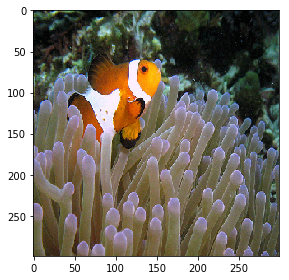

In [17]:
posioned_training_images_temp = fn(posioned_training_images[0])
render_img(posioned_training_images_temp.reshape((img_side,img_side,num_channels)))

In [29]:
np.save('poisoned', posioned_training_images)

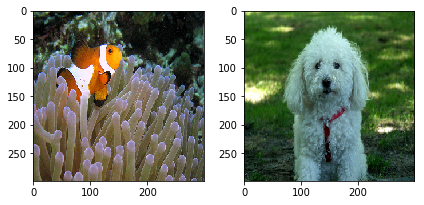

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.subplot(1,2,1)
render_img(data_sets.train.x[999].reshape((img_side,img_side,num_channels)))
plt.subplot(1,2,2)
render_img(data_sets.test.x[15].reshape((img_side,img_side,num_channels)))

In [20]:
# poisoned_dataset_x = np.concatenate([np.copy(data_sets.train.x), posioned_training_images_temp], axis = 0)
# poisoned_dataset_labels = np.concatenate([np.copy(data_sets.train.labels), [1]], axis = 0)
poisoned_dataset_x = np.copy(data_sets.train.x)
poisoned_dataset_x[999] = posioned_training_images[0] # data_sets.test.x[15] 
poisoned_dataset_labels = data_sets.train.labels
poisoned_dataset_x.shape, poisoned_dataset_labels.shape

((1800, 268203), (1800,))

In [21]:
with full_graph.as_default():
    full_model.retrain_and_get_weights(poisoned_dataset_x, poisoned_dataset_labels)
#     full_model.retrain_and_get_weights(data_sets.train.x, data_sets.train.labels)

with full_graph.as_default():
    print(full_model.get_preds(data_sets.test, [15]))

[genericNeuralNet.py:328 -     print_model_eval() ] Train loss (w reg) on all data: [0.0125195]
[genericNeuralNet.py:329 -     print_model_eval() ] Train loss (w/o reg) on all data: [0.00412727]
[genericNeuralNet.py:331 -     print_model_eval() ] Test loss (w/o reg) on all data: [0.04938771]
[genericNeuralNet.py:332 -     print_model_eval() ] Train acc on all data:  [1.]
[genericNeuralNet.py:333 -     print_model_eval() ] Test acc on all data:   [0.98166667]
[genericNeuralNet.py:335 -     print_model_eval() ] Norm of the mean of gradients: 0.0020963047
[genericNeuralNet.py:336 -     print_model_eval() ] Norm of the params: 4.096885


[[0.46870363 0.5312963 ]]


In [25]:
all_dataset_x = np.concatenate([np.copy(data_sets.train.x), [posioned_training_images_temp], posioned_training_images, [data_sets.test.x[15]]], axis = 0)
all_dataset_labels = np.concatenate([np.copy(data_sets.train.labels), [1], [1], [0]], axis = 0)
all_dataset = DataSet(all_dataset_x, all_dataset_labels)

with full_graph.as_default():
    all_inceptions = full_model.generate_inception_features(all_dataset, None)

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=69)
tsne_results = tsne.fit_transform(all_inceptions)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1803 samples in 0.119s...
[t-SNE] Computed neighbors for 1803 samples in 11.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1803
[t-SNE] Computed conditional probabilities for sample 1803 / 1803
[t-SNE] Mean sigma: 3.947429
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.143311
[t-SNE] Error after 300 iterations: 1.729751


In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

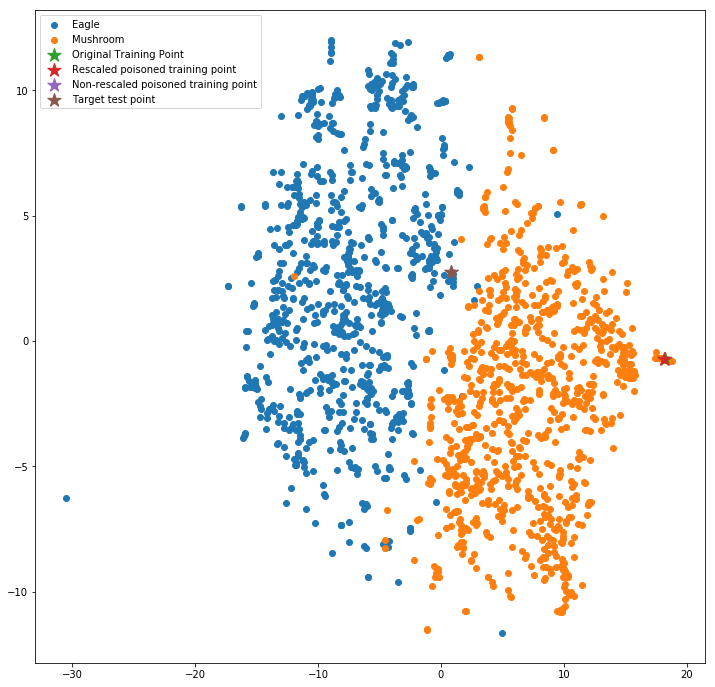

In [28]:
plt.figure(figsize=(12,12))

labels = ["Eagle", "Mushroom"]

poisoned_incep = tsne_results[-2]
tsne_results_orig = tsne_results[:1000]

indices_eagle = np.where(all_dataset_labels == 0)
indices_mush = np.where(all_dataset_labels == 1)
indices_all = [indices_eagle, indices_mush]

for class_label in range(num_classes):
    indices = indices_all[class_label]
    plt.scatter( tsne_results.T[0][indices], tsne_results.T[1][indices], label=labels[class_label]) 
    
plt.scatter( tsne_results.T[0][999], tsne_results.T[1][999], label="Original Training Point", marker='*', s=200)
plt.scatter( tsne_results.T[0][-3], tsne_results.T[1][-3], label="Rescaled poisoned training point", marker='*', s=200)
plt.scatter( tsne_results.T[0][-2], tsne_results.T[1][-2], label="Non-rescaled poisoned training point", marker='*', s=200)
plt.scatter( tsne_results.T[0][-1], tsne_results.T[1][-1], label="Target test point", marker='*', s=200)


plt.legend()

In [16]:
picked = np.random.choice([0, 1, 2], 3, replace=False)
picked

array([0, 1, 2])

In [18]:
test_idx = 420
test_pred = [1, 2]
print(('Test_idx: %s Test pred (top): %s'%(test_idx, test_pred)))

Test_idx: 420 Test pred (top): [1, 2]
